# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter middle.
Valid set: filter middle.

In [12]:
from datetime import datetime
print(datetime.now())

2023-04-01 21:25:09.500205


In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [14]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True

Python 3.9.16
sklearn 1.2.2


In [15]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [18]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [19]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 21:25:10.539403
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                65664     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [20]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [21]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 21:25:10.689280
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-01 21:25:28.508909

Training # 1 1
2023-04-01 21:25:28.510713
2023-04-01 21:25:28.511288
Discriminator ZERO -1
Train 1:0 1043:1031 50.29%
Computed class weights: {0: 1.005819592628516, 1: 0.9942473633748802}
Valid 1:0 280:262 51.66%
FIT
2023-04-01 21:25:28.561525


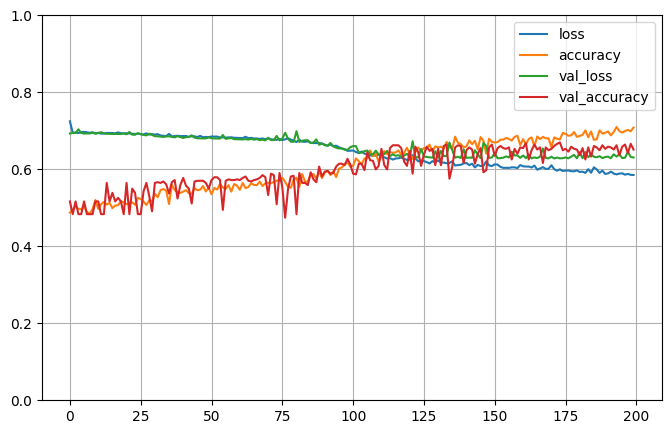


2023-04-01 21:26:08.482661

Testing # 1 1
2023-04-01 21:26:08.483116
2023-04-01 21:26:08.483147
PREDICT
2023-04-01 21:26:08.492421
Test 1:0 280:262 51.66%
Predict 1:0 281:261 51.85%
Test sizes (542, 1025) (542,)
Range of scores: 0.0012169025 to 0.96233785
Score threshold 0.5
Confusion matrix
 [[167  95]
 [ 94 186]]
Normalized matrix
 [[0.30811808 0.17527675]
 [0.17343173 0.34317343]]


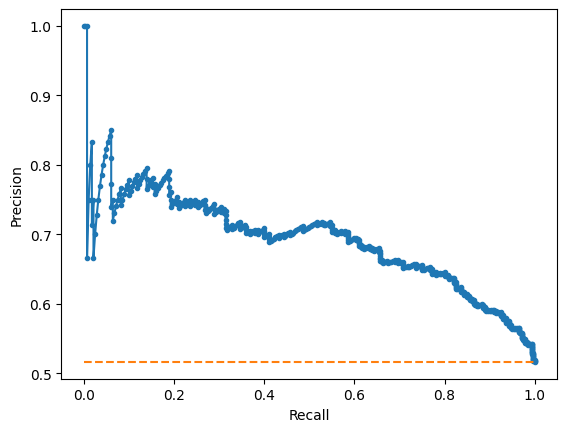

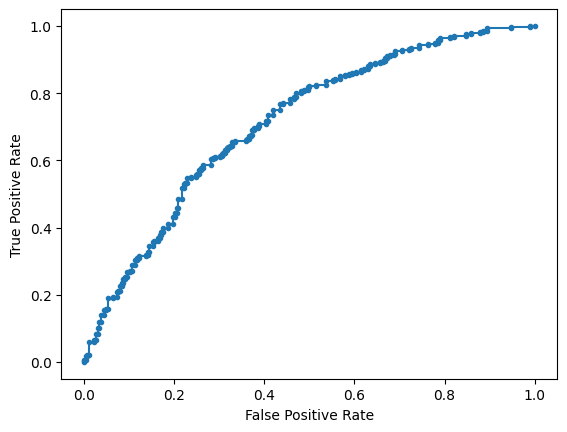

Accuracy: 65.13% Precision: 66.19% Recall: 66.43%
F1: 66.31% MCC: 0.3017
AUPRC: 69.22% AUROC: 71.18%
 accuracy [65.12915129151291]
 precision [66.19217081850533]
 recall [66.42857142857143]
 F1 [66.31016042780749]
 MCC [0.3017293704285993]
 AUPRC [69.22358576295488]
 AUROC [71.18320610687022]
2023-04-01 21:26:08.985289

Training # 1 2
2023-04-01 21:26:08.986528
2023-04-01 21:26:08.986770
Discriminator ZERO -1
Train 1:0 1074:1030 51.05%
Computed class weights: {0: 1.021359223300971, 1: 0.9795158286778398}
Valid 1:0 249:263 48.63%
FIT
2023-04-01 21:26:09.038987


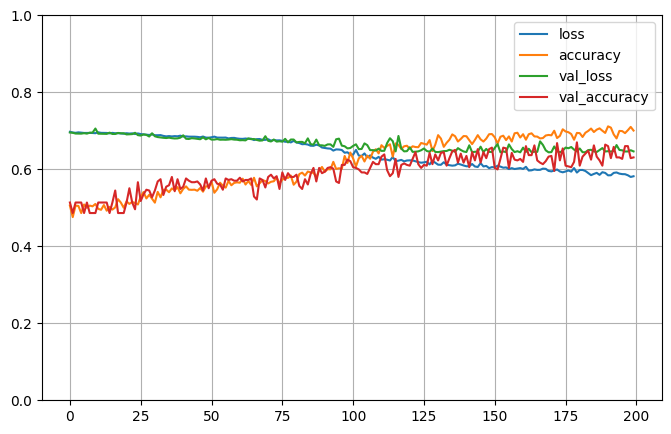


2023-04-01 21:26:50.966683

Testing # 1 2
2023-04-01 21:26:50.966825
2023-04-01 21:26:50.966871
PREDICT
2023-04-01 21:26:50.973856
Test 1:0 249:263 48.63%
Predict 1:0 236:276 46.09%
Test sizes (512, 1025) (512,)
Range of scores: 0.005297581 to 0.9890212
Score threshold 0.5
Confusion matrix
 [[175  88]
 [101 148]]
Normalized matrix
 [[0.34179688 0.171875  ]
 [0.19726562 0.2890625 ]]


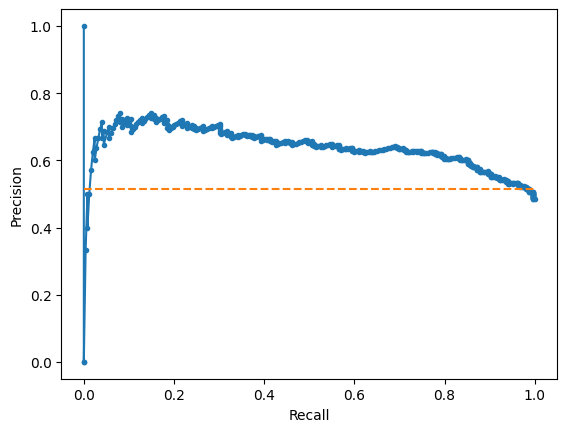

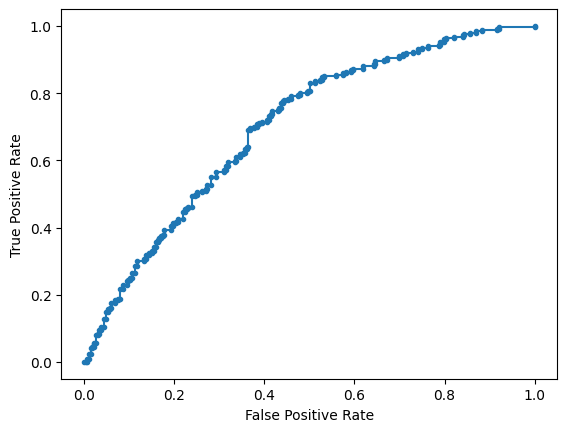

Accuracy: 63.09% Precision: 62.71% Recall: 59.44%
F1: 61.03% MCC: 0.2605
AUPRC: 64.01% AUROC: 69.96%
 accuracy [63.0859375]
 precision [62.71186440677966]
 recall [59.43775100401606]
 F1 [61.03092783505154]
 MCC [0.26047574192887735]
 AUPRC [64.0148295781798]
 AUROC [69.95586910379158]
2023-04-01 21:26:51.468105

Training # 1 3
2023-04-01 21:26:51.468264
2023-04-01 21:26:51.468299
Discriminator ZERO -1
Train 1:0 1066:1034 50.76%
Computed class weights: {0: 1.0154738878143132, 1: 0.9849906191369606}
Valid 1:0 257:259 49.81%
FIT
2023-04-01 21:26:51.522904


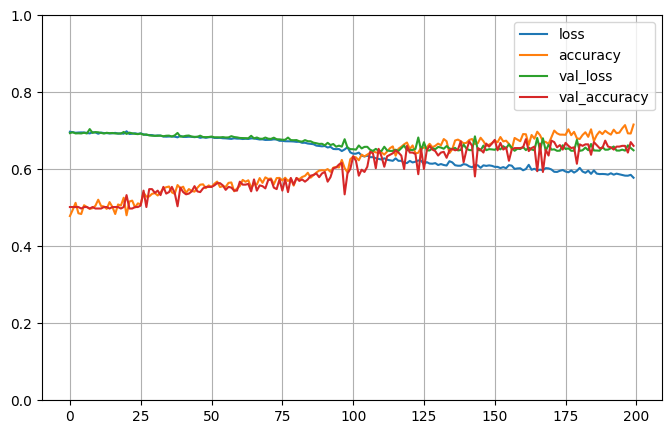


2023-04-01 21:27:32.015923

Testing # 1 3
2023-04-01 21:27:32.018264
2023-04-01 21:27:32.018677
PREDICT
2023-04-01 21:27:32.022502
Test 1:0 257:259 49.81%
Predict 1:0 282:234 54.65%
Test sizes (516, 1025) (516,)
Range of scores: 0.008068981 to 0.98719347
Score threshold 0.5
Confusion matrix
 [[159 100]
 [ 75 182]]
Normalized matrix
 [[0.30813953 0.19379845]
 [0.14534884 0.35271318]]


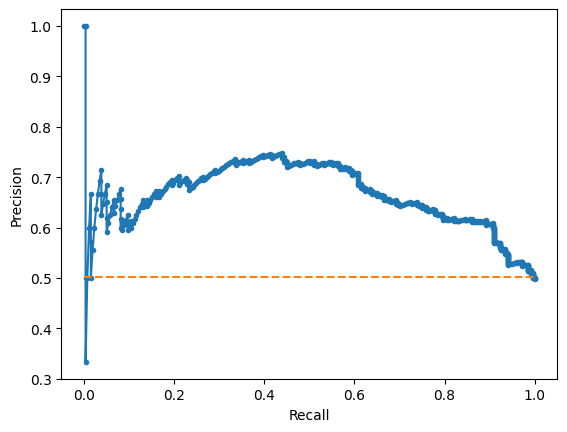

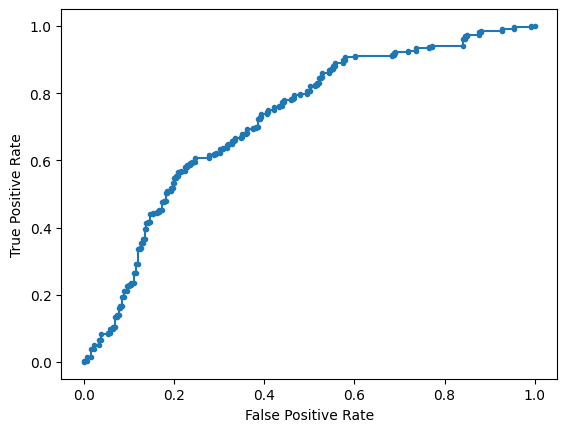

Accuracy: 66.09% Precision: 64.54% Recall: 70.82%
F1: 67.53% MCC: 0.3235
AUPRC: 66.35% AUROC: 72.11%
 accuracy [66.08527131782945]
 precision [64.53900709219859]
 recall [70.8171206225681]
 F1 [67.53246753246754]
 MCC [0.32347099171228727]
 AUPRC [66.35106950368672]
 AUROC [72.10612502441296]
2023-04-01 21:27:32.482746

Training # 1 4
2023-04-01 21:27:32.484129
2023-04-01 21:27:32.485036
Discriminator ZERO -1
Train 1:0 1055:1041 50.33%
Computed class weights: {0: 1.0067243035542748, 1: 0.9933649289099526}
Valid 1:0 268:252 51.54%
FIT
2023-04-01 21:27:32.540117


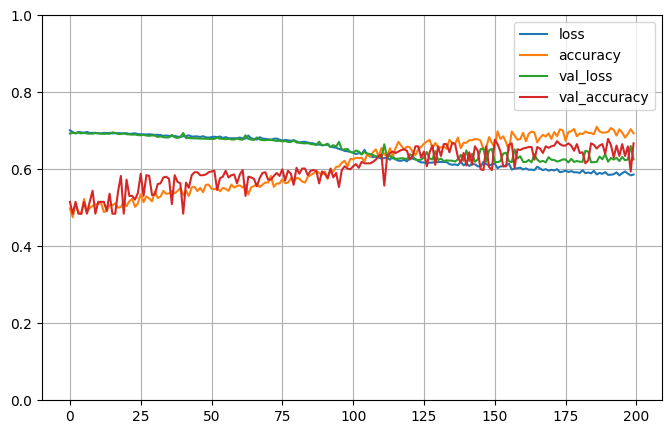


2023-04-01 21:28:14.939170

Testing # 1 4
2023-04-01 21:28:14.939498
2023-04-01 21:28:14.939561
PREDICT
2023-04-01 21:28:14.946744
Test 1:0 268:252 51.54%
Predict 1:0 223:297 42.88%
Test sizes (520, 1025) (520,)
Range of scores: 0.002960949 to 0.94531816
Score threshold 0.5
Confusion matrix
 [[188  64]
 [109 159]]
Normalized matrix
 [[0.36153846 0.12307692]
 [0.20961538 0.30576923]]


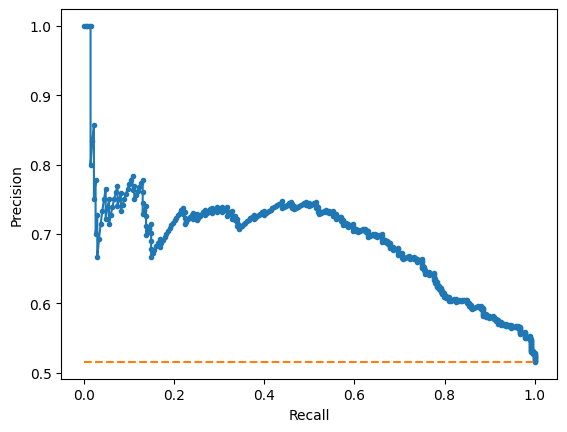

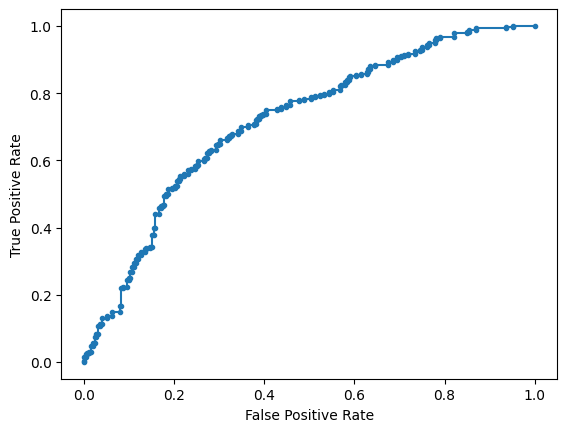

Accuracy: 66.73% Precision: 71.30% Recall: 59.33%
F1: 64.77% MCC: 0.3426
AUPRC: 69.31% AUROC: 71.57%
 accuracy [66.73076923076923]
 precision [71.30044843049326]
 recall [59.32835820895522]
 F1 [64.76578411405295]
 MCC [0.34264191606911815]
 AUPRC [69.31144257430029]
 AUROC [71.57219853115376]
2023-04-01 21:28:16.046036

Training # 1 5
2023-04-01 21:28:16.047742
2023-04-01 21:28:16.047807
Discriminator ZERO -1
Train 1:0 1054:1036 50.43%
Computed class weights: {0: 1.0086872586872586, 1: 0.99146110056926}
Valid 1:0 269:257 51.14%
FIT
2023-04-01 21:28:16.117023


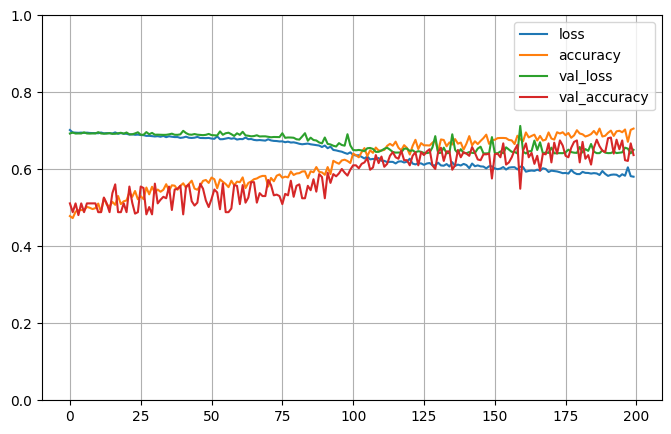


2023-04-01 21:29:02.152280

Testing # 1 5
2023-04-01 21:29:02.152418
2023-04-01 21:29:02.152464
PREDICT
2023-04-01 21:29:02.159355
Test 1:0 269:257 51.14%
Predict 1:0 210:316 39.92%
Test sizes (526, 1025) (526,)
Range of scores: 0.0025580819 to 0.98276675
Score threshold 0.5
Confusion matrix
 [[191  66]
 [125 144]]
Normalized matrix
 [[0.36311787 0.12547529]
 [0.23764259 0.27376426]]


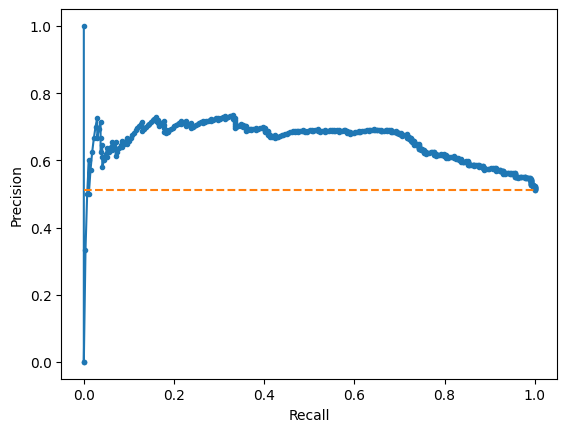

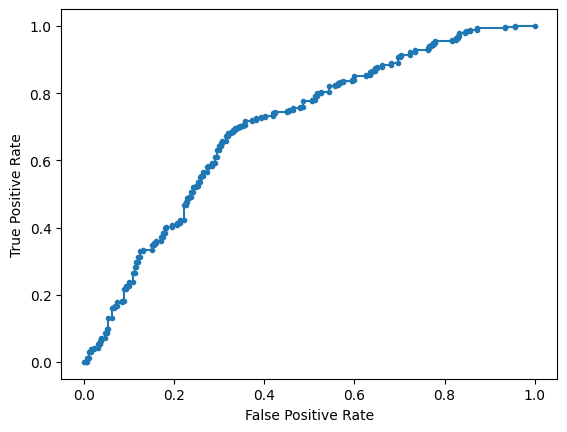

Accuracy: 63.69% Precision: 68.57% Recall: 53.53%
F1: 60.13% MCC: 0.2843
AUPRC: 65.76% AUROC: 70.05%
 accuracy [63.68821292775665]
 precision [68.57142857142857]
 recall [53.53159851301115]
 F1 [60.125260960334025]
 MCC [0.2842661038692146]
 AUPRC [65.75954297310396]
 AUROC [70.05048240348314]
2023-04-01 21:29:02.885502

Training # 2 1
2023-04-01 21:29:02.886712
2023-04-01 21:29:02.887607
Discriminator ZERO -1
Train 1:0 1049:1035 50.34%
Computed class weights: {0: 1.0067632850241546, 1: 0.9933269780743565}
Valid 1:0 274:258 51.50%
FIT
2023-04-01 21:29:02.942173


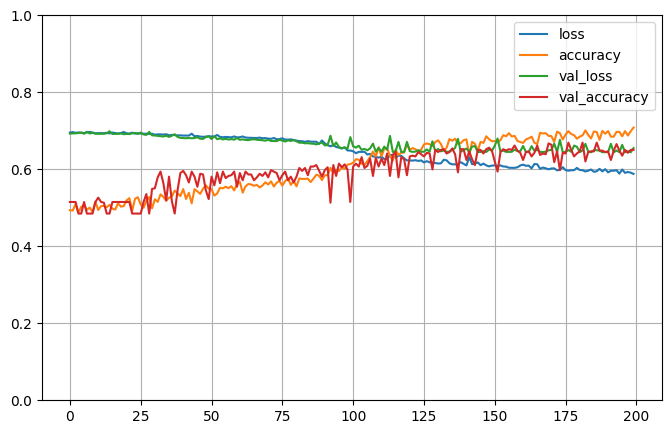


2023-04-01 21:29:48.433359

Testing # 2 1
2023-04-01 21:29:48.434960
2023-04-01 21:29:48.435315
PREDICT
2023-04-01 21:29:48.440650
Test 1:0 274:258 51.50%
Predict 1:0 216:316 40.60%
Test sizes (532, 1025) (532,)
Range of scores: 0.009433339 to 0.9749032
Score threshold 0.5
Confusion matrix
 [[194  64]
 [122 152]]
Normalized matrix
 [[0.36466165 0.12030075]
 [0.22932331 0.28571429]]


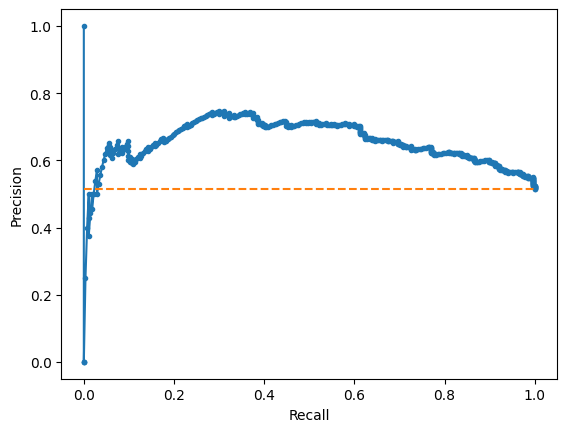

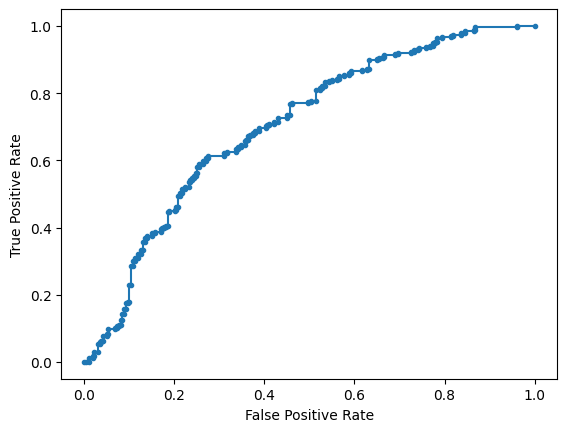

Accuracy: 65.04% Precision: 70.37% Recall: 55.47%
F1: 62.04% MCC: 0.3121
AUPRC: 65.33% AUROC: 70.32%
 accuracy [65.0375939849624]
 precision [70.37037037037037]
 recall [55.47445255474452]
 F1 [62.04081632653061]
 MCC [0.3121071562131431]
 AUPRC [65.33239215587022]
 AUROC [70.316301703163]
2023-04-01 21:29:49.312446

Training # 2 2
2023-04-01 21:29:49.314272
2023-04-01 21:29:49.314575
Discriminator ZERO -1
Train 1:0 1062:1030 50.76%
Computed class weights: {0: 1.0155339805825243, 1: 0.9849340866290018}
Valid 1:0 261:263 49.81%
FIT
2023-04-01 21:29:49.387839


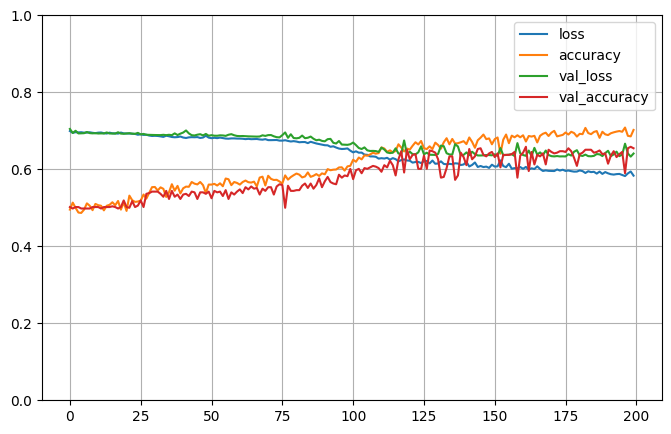


2023-04-01 21:30:32.741468

Testing # 2 2
2023-04-01 21:30:32.742886
2023-04-01 21:30:32.742919
PREDICT
2023-04-01 21:30:32.749058
Test 1:0 261:263 49.81%
Predict 1:0 200:324 38.17%
Test sizes (524, 1025) (524,)
Range of scores: 0.00665755 to 0.9720721
Score threshold 0.5
Confusion matrix
 [[203  60]
 [121 140]]
Normalized matrix
 [[0.38740458 0.11450382]
 [0.23091603 0.26717557]]


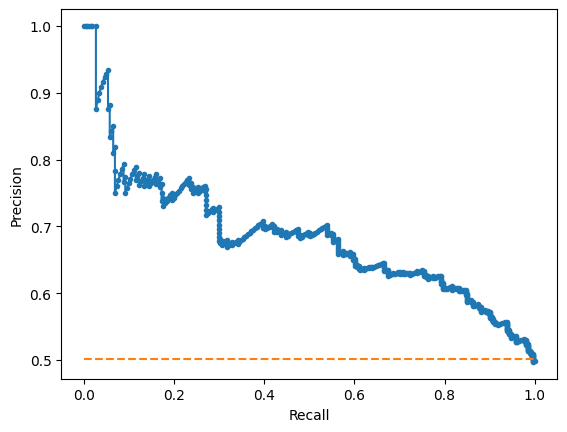

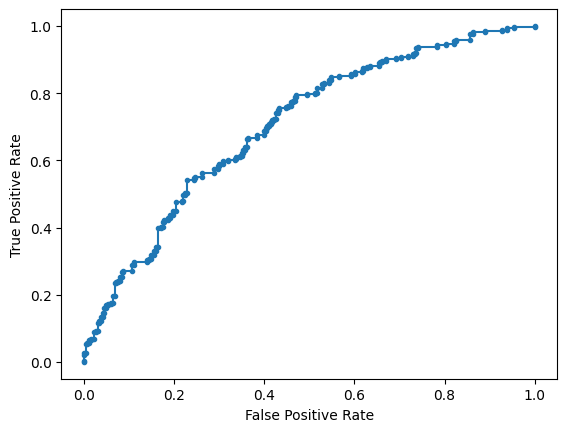

Accuracy: 65.46% Precision: 70.00% Recall: 53.64%
F1: 60.74% MCC: 0.3173
AUPRC: 68.40% AUROC: 70.33%
 accuracy [65.45801526717557]
 precision [70.0]
 recall [53.63984674329502]
 F1 [60.73752711496746]
 MCC [0.31727074801609606]
 AUPRC [68.39861039924287]
 AUROC [70.32763719534402]
2023-04-01 21:30:33.466148

Training # 2 3
2023-04-01 21:30:33.467512
2023-04-01 21:30:33.467732
Discriminator ZERO -1
Train 1:0 1047:1051 49.90%
Computed class weights: {0: 0.9980970504281637, 1: 1.0019102196752627}
Valid 1:0 276:242 53.28%
FIT
2023-04-01 21:30:33.522890


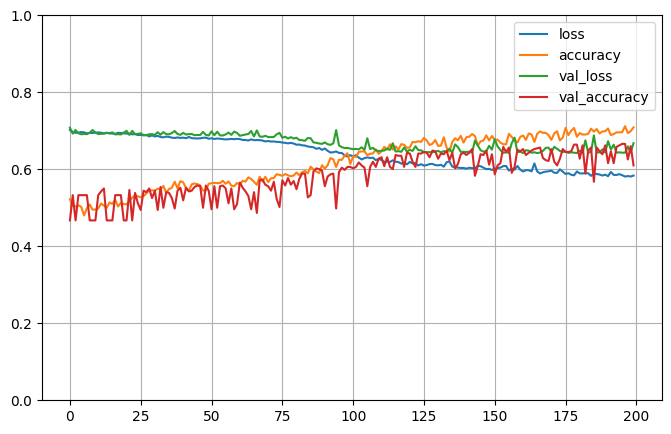


2023-04-01 21:31:56.456893

Testing # 2 3
2023-04-01 21:31:56.458388
2023-04-01 21:31:56.458770
PREDICT
2023-04-01 21:31:56.462504
Test 1:0 276:242 53.28%
Predict 1:0 426:92 82.24%
Test sizes (518, 1025) (518,)
Range of scores: 0.0027454474 to 0.9828356
Score threshold 0.5
Confusion matrix
 [[ 66 176]
 [ 26 250]]
Normalized matrix
 [[0.12741313 0.33976834]
 [0.05019305 0.48262548]]


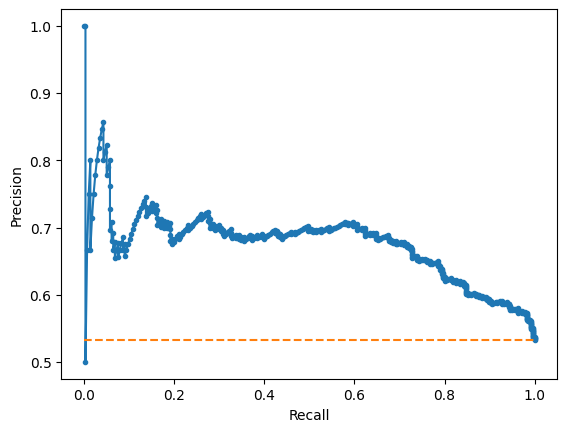

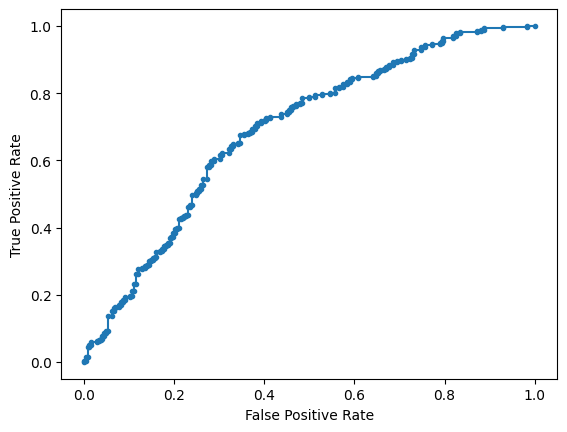

Accuracy: 61.00% Precision: 58.69% Recall: 90.58%
F1: 71.23% MCC: 0.2331
AUPRC: 67.63% AUROC: 69.00%
 accuracy [61.003861003861005]
 precision [58.68544600938967]
 recall [90.57971014492753]
 F1 [71.22507122507122]
 MCC [0.23305639809459003]
 AUPRC [67.62669123845706]
 AUROC [68.99928135106]
2023-04-01 21:31:57.113936

Training # 2 4
2023-04-01 21:31:57.114821
2023-04-01 21:31:57.114880
Discriminator ZERO -1
Train 1:0 1068:1024 51.05%
Computed class weights: {0: 1.021484375, 1: 0.9794007490636704}
Valid 1:0 255:269 48.66%
FIT
2023-04-01 21:31:57.174130


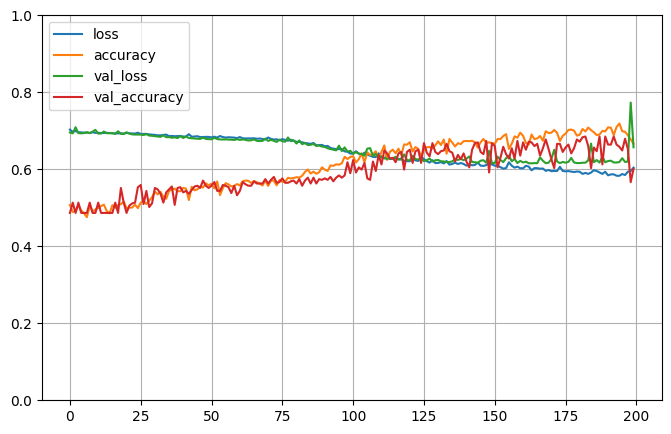


2023-04-01 21:32:39.986731

Testing # 2 4
2023-04-01 21:32:39.987034
2023-04-01 21:32:39.992507
PREDICT
2023-04-01 21:32:39.996469
Test 1:0 255:269 48.66%
Predict 1:0 422:102 80.53%
Test sizes (524, 1025) (524,)
Range of scores: 0.0025493589 to 0.9649168
Score threshold 0.5
Confusion matrix
 [[ 81 188]
 [ 21 234]]
Normalized matrix
 [[0.15458015 0.35877863]
 [0.04007634 0.44656489]]


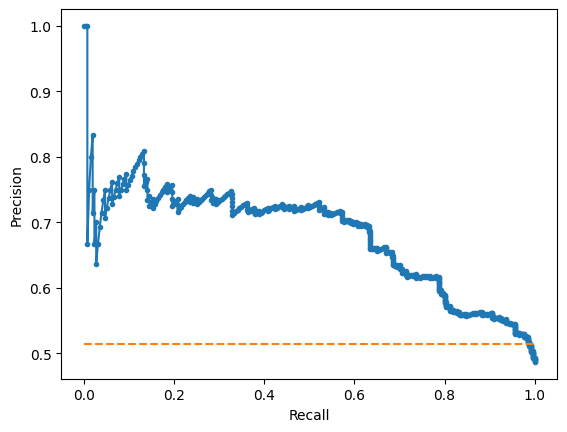

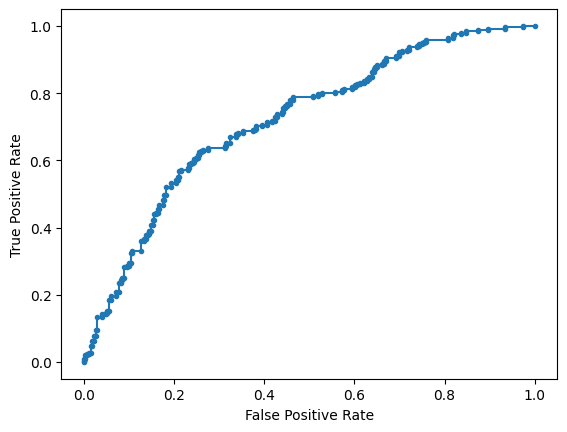

Accuracy: 60.11% Precision: 55.45% Recall: 91.76%
F1: 69.13% MCC: 0.2762
AUPRC: 67.93% AUROC: 71.91%
 accuracy [60.1145038167939]
 precision [55.45023696682464]
 recall [91.76470588235294]
 F1 [69.1285081240768]
 MCC [0.27616103426324395]
 AUPRC [67.9307616006826]
 AUROC [71.91486259931482]
2023-04-01 21:32:40.699880

Training # 2 5
2023-04-01 21:32:40.706209
2023-04-01 21:32:40.706532
Discriminator ZERO -1
Train 1:0 1066:1032 50.81%
Computed class weights: {0: 1.0164728682170543, 1: 0.9840525328330206}
Valid 1:0 257:261 49.61%
FIT
2023-04-01 21:32:40.762838


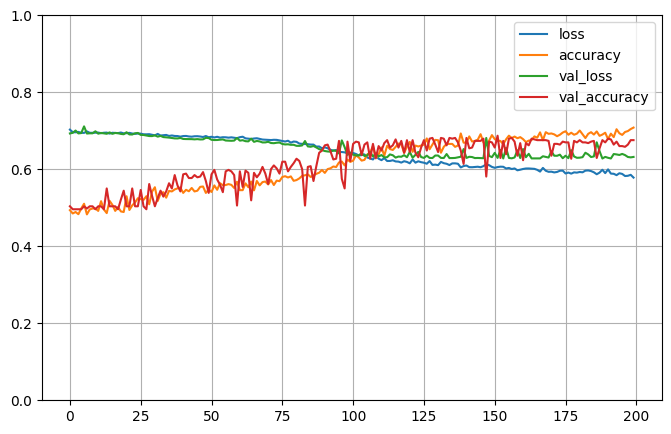


2023-04-01 21:33:22.825142

Testing # 2 5
2023-04-01 21:33:22.833094
2023-04-01 21:33:22.833503
PREDICT
2023-04-01 21:33:22.843062
Test 1:0 257:261 49.61%
Predict 1:0 305:213 58.88%
Test sizes (518, 1025) (518,)
Range of scores: 0.0019501065 to 0.9850909
Score threshold 0.5
Confusion matrix
 [[153 108]
 [ 60 197]]
Normalized matrix
 [[0.2953668  0.20849421]
 [0.11583012 0.38030888]]


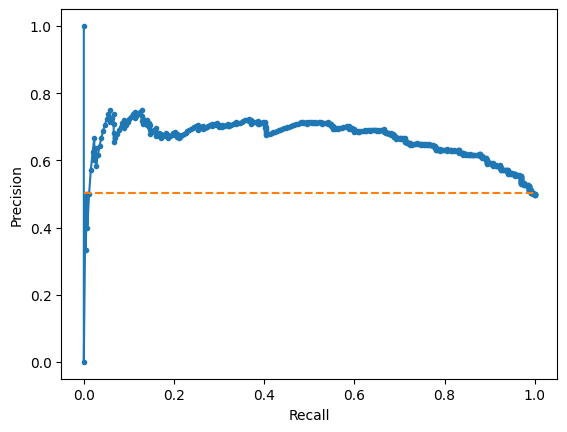

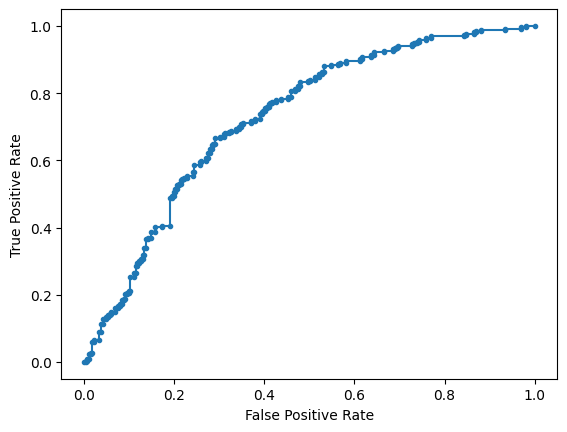

Accuracy: 67.57% Precision: 64.59% Recall: 76.65%
F1: 70.11% MCC: 0.3584
AUPRC: 66.50% AUROC: 72.69%
 accuracy [67.56756756756756]
 precision [64.59016393442623]
 recall [76.65369649805449]
 F1 [70.10676156583631]
 MCC [0.35843182112510474]
 AUPRC [66.50276592077088]
 AUROC [72.69406801138989]
2023-04-01 21:33:23.494218


In [22]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [23]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 64.39% std 2.42
 precision mean 65.24% std 5.20
 recall mean 67.77% std 14.45
 F1 mean 65.30% std 4.16
 MCC mean 0.30% std 0.04
 AUPRC mean 67.05% std 1.74
 AUROC mean 70.91% std 1.16
 accuracy [[65.12915129151291], [63.0859375], [66.08527131782945], [66.73076923076923], [63.68821292775665], [65.0375939849624], [65.45801526717557], [61.003861003861005], [60.1145038167939], [67.56756756756756]]
 precision [[66.19217081850533], [62.71186440677966], [64.53900709219859], [71.30044843049326], [68.57142857142857], [70.37037037037037], [70.0], [58.68544600938967], [55.45023696682464], [64.59016393442623]]
 recall [[66.42857142857143], [59.43775100401606], [70.8171206225681], [59.32835820895522], [53.53159851301115], [55.47445255474452], [53.63984674329502], [90.57971014492753], [91.76470588235294], [76.65369649805449]]
 F1 [[66.31016042780749], [61.03092783505154], [67.53246753246754], [64.76578411405295], [60.125260960334025], [62.04081632653061], [60.73752711496746], [71.2250